In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/ANN2DL/homework2/Alberto

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/ANN2DL/homework2/Alberto


In [3]:
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [4]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [5]:
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [109]:
# dataset_dir = 'dataset'
dataset_dir = 'data'
dataset = np.load(f'{dataset_dir}/training_data.npy')
df = pd.DataFrame(dataset)
valid_periods = np.load(f'{dataset_dir}/valid_periods.npy')

In [78]:
data0 = [data for data in dataset[0] if data!=0]

# ANOMALY DETECTION

### Z-score method

In [10]:
#First we have to check if our data is normally distributed
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import shapiro
from scipy.stats import kstest

Text(0.5, 1.0, 'Histogram of Time Series Data')

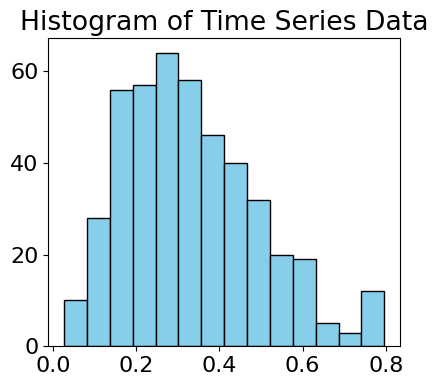

In [63]:
plt.figure(figsize=(10, 4))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(data0, bins='auto', color='skyblue', edgecolor='black')
plt.title('Histogram of Time Series Data')

In [13]:
count_shapiroNormallyDistributed = 0;
count_shapiroNotNormallyDistributed = 0;
count_kolmogorovSmirnovNormallyDistributed = 0;
count_kolmogorovSmirnovNotNormallyDistributed = 0;
alpha = 0.05
p_values = []

for data in dataset:
  notZeroData = [x for x in data if x!=0]
  stat, p = shapiro(notZeroData)
  p_values.append(p)

  if p > alpha:
      count_shapiroNormallyDistributed += 1
  else:
      count_shapiroNotNormallyDistributed += 1

  stat, p = kstest(notZeroData, 'norm', alternative='two-sided', mode='asymp')
  if p > alpha:
      count_kolmogorovSmirnovNormallyDistributed += 1
  else:
      count_kolmogorovSmirnovNotNormallyDistributed +=1

count_shapiroNormallyDistributed , count_shapiroNotNormallyDistributed , count_kolmogorovSmirnovNormallyDistributed, count_kolmogorovSmirnovNotNormallyDistributed, np.mean(p_values)

(4431, 43569, 0, 48000, 0.025985187415771705)

In [79]:
# Even though data does not look normally distributed, we will try to apply anyway robust z-score
mean = np.mean(data0)
std = np.std(data0)
mean, std

(0.3353497942386831, 0.1670674181591601)

In [80]:
def compute_z_score(x):
  return (x-mean)/std

In [81]:
Z_scores_data0 = [compute_z_score(data) for data in data0 ]
len(data0), len(Z_scores_data0)

(450, 450)

In [82]:
df_data0 = pd.DataFrame({'Values':data0,'Z_scores':Z_scores_data0})

In [ ]:
df_data0

,Values,Z_scores
0,0.491667,0.935651
1,0.524074,1.129629
2,0.544444,1.251559
3,0.463889,0.769385
4,0.406481,0.425766
...,...,...
445,0.640741,1.827950
446,0.516667,1.085292
447,0.602778,1.600719
448,0.367593,0.192993


In [83]:
outliers0_using_Z_scores = df_data0[abs(df_data0['Z_scores']) > 3]

In [84]:
outliers0_using_Z_scores

,Values,Z_scores
408,0.850000,3.080494
409,0.947222,3.662428
419,0.891667,3.329894
420,1.000000,3.978335
421,0.927778,3.546041
432,0.845370,3.052783


In [ ]:
# Replace outliers with mean value
threshold = 3
df_data0.loc[abs(df_data0['Z_scores']) > threshold, 'Values'] = mean

### Isolation Forest



In [110]:
from sklearn.ensemble import IsolationForest

In [111]:
df_data0 = pd.DataFrame({'Values':data0})
iso_forest = IsolationForest(contamination=6/450,random_state=42) # 6/450
outlier_labels = iso_forest.fit_predict(df_data0)
df_data0['Outlier'] = outlier_labels

In [112]:
outliers = df_data0[df_data0['Outlier'] == -1]
outliers

,Values,Outlier
295,0.026852,-1
408,0.850000,-1
409,0.947222,-1
419,0.891667,-1
420,1.000000,-1
421,0.927778,-1


### LOCAL OUTLIER FACTOR

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

In [ ]:
lof = LocalOutlierFactor(n_neighbors=10,contamination=1/450)

In [ ]:
preds_lof = lof.fit_predict(df_data0)
df_data0['Outlier'] = preds_lof

In [ ]:
outliers = df_data0[df_data0['Outlier'] == -1]
outliers

,Values,Outlier
295,0.026852,-1
408,0.850000,-1
409,0.947222,-1
419,0.891667,-1
420,1.000000,-1
421,0.927778,-1


### Let's try Z-score in all DataFrame

In [113]:
## Let's try Z-score in all dataframe
def compute_z_score(x,mean,std):
  return (x-mean)/std

for i in range(len(valid_periods)):
  data = df.iloc[i,valid_periods[i][0]:]
  mean = np.mean(data)
  std = np.std(data)
  for index in range(len(data)):
    if (compute_z_score(data.iloc[index],mean,std) > 3):
      print('Pre: ' + str(df.iloc[i,valid_periods[i][0]+index]))
      if (index==0 or index==len(data)-1):
        df.iloc[i,valid_periods[i][0]+index] = mean
      else:
        df.iloc[i,valid_periods[i][0]+index] = mean#(data.iloc[index-1]+data.iloc[index+1])/2

      print('After: ' + str(df.iloc[i,valid_periods[i][0]+index]))

Output streaming troncato alle ultime 5000 righe.
Pre: 0.7689910459619711
After: 0.2574749179101863
Pre: 0.807089557223197
After: 0.2574749179101863
Pre: 1.0
After: 0.332539140960258
Pre: 0.9708180416512847
After: 0.34132354362227213
Pre: 0.7188226181254841
After: 0.26298827044373135
Pre: 0.8808290155440415
After: 0.3554774241302739
Pre: 1.0
After: 0.2989208021698992
Pre: 0.6600102212716019
After: 0.2214193499433267
Pre: 0.5971588650602865
After: 0.2214193499433267
Pre: 0.6812977099236641
After: 0.21111641221374042
Pre: 0.7794759825327511
After: 0.2415393013100437
Pre: 0.7648085477725987
After: 0.2704547877440014
Pre: 0.7582742694165976
After: 0.2704547877440014
Pre: 1.0
After: 0.14377844405545967
Pre: 1.0
After: 0.2289812988699486
Pre: 0.5845987971828757
After: 0.17132082161172935
Pre: 0.6149244282662025
After: 0.17132082161172935
Pre: 0.5805986389174647
After: 0.17132082161172935
Pre: 0.5833386088470365
After: 0.17132082161172935
Pre: 0.5964805729207882
After: 0.17132082161172935
Pre